<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session8/Session8LN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks is all about having a potent classifier for Cifar-10 dataset with the following considerations:
* Make this network: C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11 cN is 1x1 Layer
* Keep the parameter count less than 50000
* Max Epochs is 20
* Use of Layer Normalization with DP

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [11]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.6 MB/s eta 0:00:00


## Helpers and Utils

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns
import torch.nn.functional as F

In [13]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [14]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [15]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [16]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 128
epochs = 20
lr = 1e-3

Random seed set as 42
cuda


In [17]:
class EarlyStopping:

    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = "checkpoint.pt"
        self.trace_func = trace_func
    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Dataloader and pre-processing

In [18]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])


In [19]:
# downloading train and test data
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 43531705.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [20]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

In [22]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [23]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [24]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

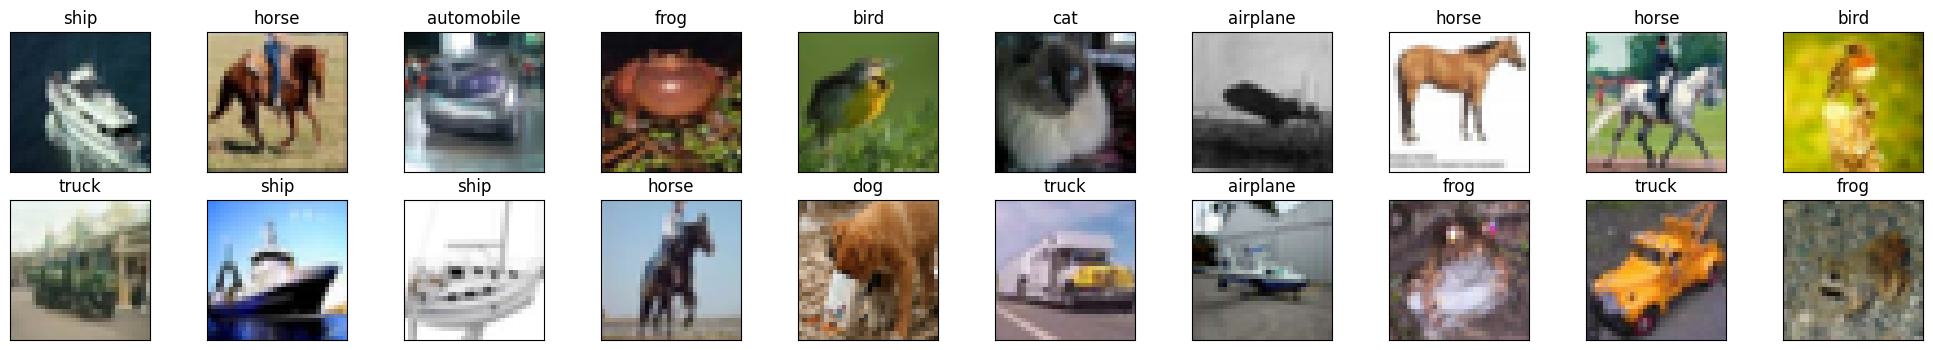

In [25]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Model Building and optimization

In [30]:
class Cifar_Baseline_DP(nn.Module):

  @staticmethod
  def calc_activation_shape(
        dim, ksize, dilation=(1, 1), stride=(1, 1), padding=(0, 0)
    ):
      def shape_each_dim(i):
          odim_i = dim[i] + 2 * padding[i] - dilation[i] * (ksize[i] - 1) - 1
          return (odim_i / stride[i]) + 1


      return shape_each_dim(0), shape_each_dim(1)

  def __init__(self, in_channels, hidden_units, out_channels, multiplier=1):
    super(Cifar_Baseline_DP, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), # 30,3
        nn.LayerNorm([multiplier*hidden_units,30,30]),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units,  kernel_size=3, stride=1, padding=0), #28,5
        nn.LayerNorm([multiplier*hidden_units,28,28]),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #28,6
        nn.LayerNorm([hidden_units,28,28]),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #14,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #12,10
        nn.LayerNorm([multiplier*hidden_units,12,12]),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #10,14
        nn.LayerNorm([multiplier*hidden_units,10,10]),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #8,18
        nn.LayerNorm([multiplier*hidden_units,8,8]),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.transition2= nn.Sequential(
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #8,20
        nn.LayerNorm([hidden_units,8,8]),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #4,20
    )

    self.conv3 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=multiplier*hidden_units, kernel_size=3, stride=1, padding=0), #2,28
        nn.LayerNorm([multiplier*hidden_units,2,2]),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=multiplier*hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,36
        nn.LayerNorm([hidden_units,2,2]),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #2,44
        nn.LayerNorm([hidden_units,2,2]),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.gap = self.gap = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=1, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition1(x)
      x = self.conv2(x)
      x = self.transition2(x)
      x = self.conv3(x)
      x = self.gap(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [31]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [32]:
# updated testing modules---
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [34]:
# New Model Instance
baseline_model_1 = Cifar_Baseline_DP(in_channels=3, hidden_units=8, out_channels=10 , multiplier=2).to(device)
summary(baseline_model_1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
         LayerNorm-2           [-1, 16, 30, 30]          28,800
              ReLU-3           [-1, 16, 30, 30]               0
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 16, 28, 28]           2,320
         LayerNorm-6           [-1, 16, 28, 28]          25,088
              ReLU-7           [-1, 16, 28, 28]               0
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             136
        LayerNorm-10            [-1, 8, 28, 28]          12,544
             ReLU-11            [-1, 8, 28, 28]               0
        MaxPool2d-12            [-1, 8, 14, 14]               0
           Conv2d-13           [-1, 16, 12, 12]           1,168
        LayerNorm-14           [-1, 16,

In [35]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_1.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [36]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_1, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], baseline_model_1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 2.10541734975927 Avg Train Metric: 0.1434942405585133: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]


Function Took 18.8513 seconds


Avg Test Loss: 1.8568145081966738 Avg Test Metric: 0.2919793245913107: 100%|██████████| 79/79 [00:03<00:00, 24.26it/s]


Function Took 3.2658 seconds
Validation loss decreased (inf --> 1.856815).  Saving model ...
Epoch 1


Avg Train Loss: 1.7839776570229884 Avg Train Metric: 0.30496976610339815: 100%|██████████| 391/391 [00:19<00:00, 19.59it/s]


Function Took 19.9703 seconds


Avg Test Loss: 1.6537654098076155 Avg Test Metric: 0.38170607859575295: 100%|██████████| 79/79 [00:02<00:00, 29.07it/s]


Function Took 2.7253 seconds
Validation loss decreased (1.856815 --> 1.653765).  Saving model ...
Epoch 2


Avg Train Loss: 1.637446957780882 Avg Train Metric: 0.37947182742226154: 100%|██████████| 391/391 [00:19<00:00, 20.19it/s]


Function Took 19.3743 seconds


Avg Test Loss: 1.5136857741995702 Avg Test Metric: 0.451440097033223: 100%|██████████| 79/79 [00:03<00:00, 22.95it/s]


Function Took 3.4519 seconds
Validation loss decreased (1.653765 --> 1.513686).  Saving model ...
Epoch 3


Avg Train Loss: 1.5348836765874683 Avg Train Metric: 0.42753413052815: 100%|██████████| 391/391 [00:18<00:00, 21.36it/s]


Function Took 18.3109 seconds


Avg Test Loss: 1.408192347122144 Avg Test Metric: 0.492683712440201: 100%|██████████| 79/79 [00:03<00:00, 20.72it/s]


Function Took 3.8182 seconds
Validation loss decreased (1.513686 --> 1.408192).  Saving model ...
Epoch 4


Avg Train Loss: 1.4603023913205433 Avg Train Metric: 0.460708758562727: 100%|██████████| 391/391 [00:18<00:00, 21.15it/s]


Function Took 18.4943 seconds


Avg Test Loss: 1.4218006420739089 Avg Test Metric: 0.48794998511483395: 100%|██████████| 79/79 [00:02<00:00, 28.28it/s]


Function Took 2.8028 seconds
EarlyStopping counter: 1 out of 3
Epoch 5


Avg Train Loss: 1.4010474605633474 Avg Train Metric: 0.48357641110029975: 100%|██████████| 391/391 [00:21<00:00, 18.25it/s]


Function Took 21.4322 seconds


Avg Test Loss: 1.348572608036331 Avg Test Metric: 0.5043311488779285: 100%|██████████| 79/79 [00:03<00:00, 20.84it/s]


Function Took 3.8058 seconds
Validation loss decreased (1.408192 --> 1.348573).  Saving model ...
Epoch 6


Avg Train Loss: 1.361439282327052 Avg Train Metric: 0.5048104212869464: 100%|██████████| 391/391 [00:24<00:00, 15.81it/s]


Function Took 24.7497 seconds


Avg Test Loss: 1.3065255759637566 Avg Test Metric: 0.5197777438767349: 100%|██████████| 79/79 [00:04<00:00, 19.70it/s]


Function Took 4.0252 seconds
Validation loss decreased (1.348573 --> 1.306526).  Saving model ...
Epoch 7


Avg Train Loss: 1.3318169848693302 Avg Train Metric: 0.511952510041654: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]


Function Took 22.9162 seconds


Avg Test Loss: 1.2626070810269705 Avg Test Metric: 0.5386881179447416: 100%|██████████| 79/79 [00:04<00:00, 16.90it/s]


Function Took 4.6920 seconds
Validation loss decreased (1.306526 --> 1.262607).  Saving model ...
Epoch 8


Avg Train Loss: 1.303363264978999 Avg Train Metric: 0.5309139651715603: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Function Took 23.0571 seconds


Avg Test Loss: 1.236464340475541 Avg Test Metric: 0.54863164092921: 100%|██████████| 79/79 [00:03<00:00, 22.88it/s]


Function Took 3.4661 seconds
Validation loss decreased (1.262607 --> 1.236464).  Saving model ...
Epoch 9


Avg Train Loss: 1.2674877015526032 Avg Train Metric: 0.5414317443852534: 100%|██████████| 391/391 [00:19<00:00, 20.47it/s]


Function Took 19.1068 seconds


Avg Test Loss: 1.2225241102749789 Avg Test Metric: 0.5544620065749446: 100%|██████████| 79/79 [00:02<00:00, 27.88it/s]


Function Took 2.8428 seconds
Validation loss decreased (1.236464 --> 1.222524).  Saving model ...
Epoch 10


Avg Train Loss: 1.249456429268088 Avg Train Metric: 0.5478419361212065: 100%|██████████| 391/391 [00:21<00:00, 18.54it/s]


Function Took 21.0960 seconds


Avg Test Loss: 1.2251691154286832 Avg Test Metric: 0.5559412127808679: 100%|██████████| 79/79 [00:02<00:00, 27.48it/s]


Function Took 2.8815 seconds
EarlyStopping counter: 1 out of 3
Epoch 11


Avg Train Loss: 1.2411203058174505 Avg Train Metric: 0.5546973147965453: 100%|██████████| 391/391 [00:20<00:00, 19.42it/s]


Function Took 20.1449 seconds


Avg Test Loss: 1.1836581011361713 Avg Test Metric: 0.573553857924063: 100%|██████████| 79/79 [00:02<00:00, 26.47it/s]


Function Took 2.9915 seconds
Validation loss decreased (1.222524 --> 1.183658).  Saving model ...
Epoch 12


Avg Train Loss: 1.2114846428946766 Avg Train Metric: 0.569126906602279: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]


Function Took 18.8689 seconds


Avg Test Loss: 1.2256332311449172 Avg Test Metric: 0.562742604485041: 100%|██████████| 79/79 [00:03<00:00, 21.94it/s]


Function Took 3.6092 seconds
EarlyStopping counter: 1 out of 3
Epoch 13


Avg Train Loss: 1.2036378272354145 Avg Train Metric: 0.5687341283044547: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s]


Function Took 18.7628 seconds


Avg Test Loss: 1.145227624645716 Avg Test Metric: 0.5933583009092114: 100%|██████████| 79/79 [00:02<00:00, 28.31it/s]


Function Took 2.8012 seconds
Validation loss decreased (1.183658 --> 1.145228).  Saving model ...
Epoch 14


Avg Train Loss: 1.1818550402855934 Avg Train Metric: 0.5783171293985508: 100%|██████████| 391/391 [00:20<00:00, 19.50it/s]


Function Took 20.0552 seconds


Avg Test Loss: 1.1410076293764235 Avg Test Metric: 0.6010278916057152: 100%|██████████| 79/79 [00:02<00:00, 27.59it/s]


Function Took 2.8721 seconds
Validation loss decreased (1.145228 --> 1.141008).  Saving model ...
Epoch 15


Avg Train Loss: 1.1713425088721467 Avg Train Metric: 0.5839235712500179: 100%|██████████| 391/391 [00:19<00:00, 20.05it/s]


Function Took 19.5062 seconds


Avg Test Loss: 1.1658797271644012 Avg Test Metric: 0.5892551752585399: 100%|██████████| 79/79 [00:04<00:00, 17.54it/s]


Function Took 4.5129 seconds
EarlyStopping counter: 1 out of 3
Epoch 16


Avg Train Loss: 1.1557117746309247 Avg Train Metric: 0.5900433380585497: 100%|██████████| 391/391 [00:19<00:00, 20.52it/s]


Function Took 19.0624 seconds


Avg Test Loss: 1.1101525788065754 Avg Test Metric: 0.596185223211216: 100%|██████████| 79/79 [00:02<00:00, 27.53it/s]


Function Took 2.8778 seconds
Validation loss decreased (1.141008 --> 1.110153).  Saving model ...
Epoch 17


Avg Train Loss: 1.142745125019337 Avg Train Metric: 0.5968219845191293: 100%|██████████| 391/391 [00:19<00:00, 19.62it/s]


Function Took 19.9347 seconds


Avg Test Loss: 1.1028797256795666 Avg Test Metric: 0.6179035939747775: 100%|██████████| 79/79 [00:02<00:00, 27.88it/s]


Function Took 2.8406 seconds
Validation loss decreased (1.110153 --> 1.102880).  Saving model ...
Epoch 18


Avg Train Loss: 1.1289751747685015 Avg Train Metric: 0.6040379647403726: 100%|██████████| 391/391 [00:20<00:00, 19.42it/s]


Function Took 20.1395 seconds


Avg Test Loss: 1.0952884811389296 Avg Test Metric: 0.6083117685740507: 100%|██████████| 79/79 [00:02<00:00, 27.13it/s]


Function Took 2.9189 seconds
Validation loss decreased (1.102880 --> 1.095288).  Saving model ...
Epoch 19


Avg Train Loss: 1.1149715974812617 Avg Train Metric: 0.608608779395023: 100%|██████████| 391/391 [00:19<00:00, 20.41it/s]


Function Took 19.1679 seconds


Avg Test Loss: 1.1131343592571308 Avg Test Metric: 0.5915943338901182: 100%|██████████| 79/79 [00:03<00:00, 20.57it/s]

Function Took 3.8493 seconds
EarlyStopping counter: 1 out of 3


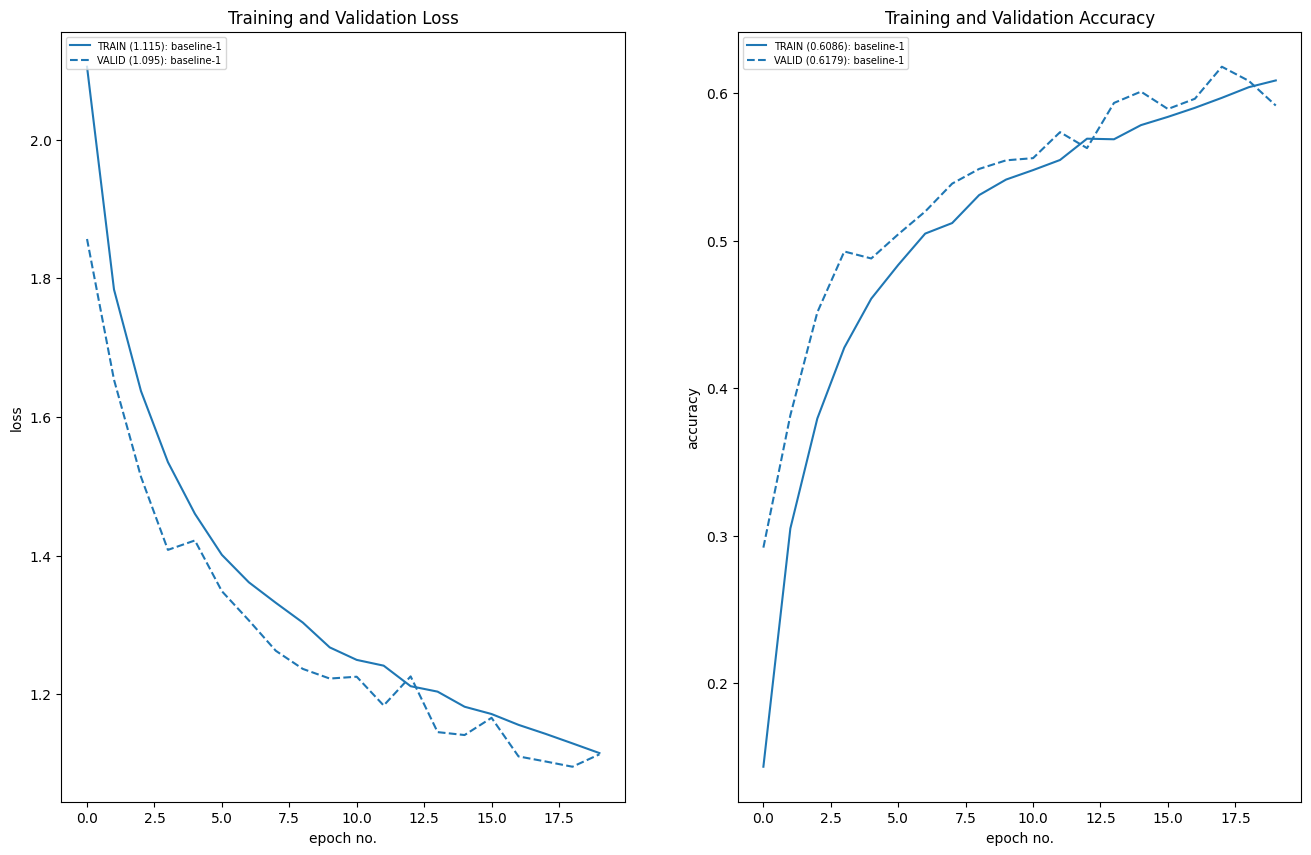

In [47]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

## Eval Framework and Metrics

In [38]:
def eval_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                ):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  predictions = []
  actuals = []

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      actuals.append(label)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      # metric calc
      preds = torch.argmax(preds,dim=1)

      predictions.append(preds)

  return torch.cat(actuals, dim=0).cpu().numpy(), torch.cat(predictions, dim=0).cpu().numpy()

In [39]:
eval_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
actuals , predictions = eval_module(baseline_model_1, device, eval_loader)

100%|██████████| 79/79 [00:02<00:00, 31.95it/s]


In [40]:
min(actuals),max(actuals)

(0, 9)

## Metrics

In [41]:
cmatrix = confusion_matrix(actuals, predictions)
print(classification_report(actuals, predictions, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.67      0.58      0.62      1000
  automobile       0.72      0.83      0.77      1000
        bird       0.44      0.47      0.45      1000
         cat       0.37      0.35      0.36      1000
        deer       0.50      0.42      0.46      1000
         dog       0.54      0.45      0.49      1000
        frog       0.57      0.80      0.67      1000
       horse       0.80      0.56      0.66      1000
        ship       0.67      0.81      0.73      1000
       truck       0.74      0.71      0.73      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.59     10000
weighted avg       0.60      0.60      0.59     10000



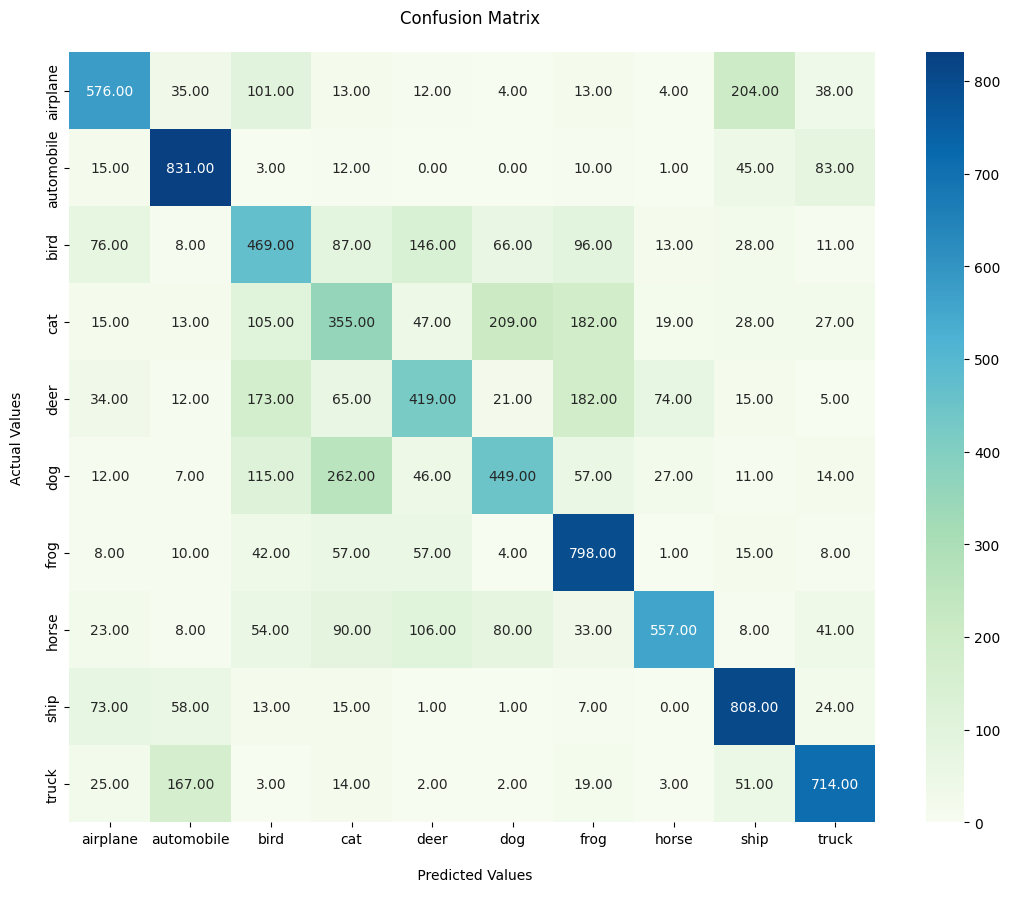

In [42]:
plt.figure(figsize=(13,10))
fx=sns.heatmap(cmatrix, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(classes)
fx.yaxis.set_ticklabels(classes)
plt.show()

In [43]:
mismatches = np.where(predictions != actuals)

In [44]:
# idx = mismatches[0][0]
# print(f'Actual: {classes[actuals[idx]]}')
# print(f'Predicted: {classes[predictions[idx]]}')

Label: cat and Prediction: truck


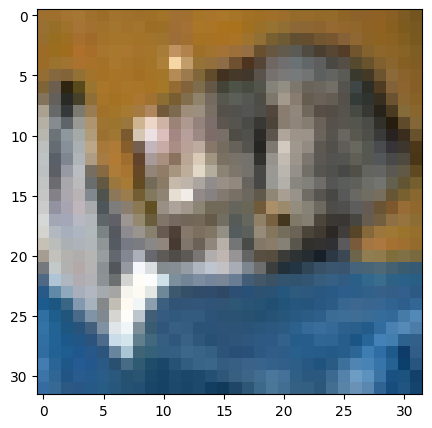

Label: airplane and Prediction: ship


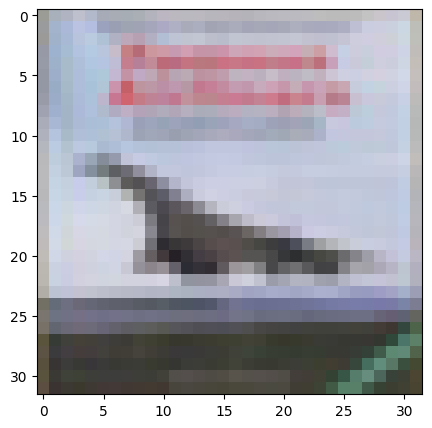

Label: frog and Prediction: deer


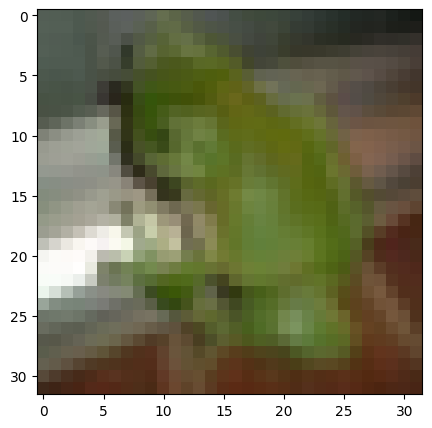

Label: cat and Prediction: dog


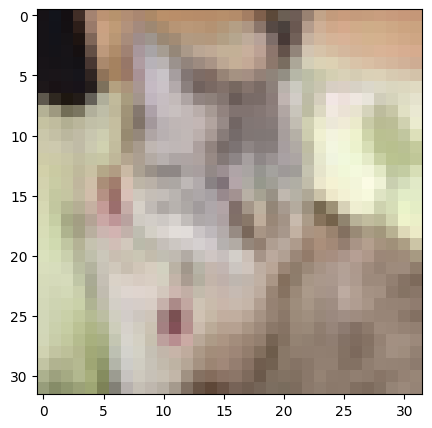

Label: airplane and Prediction: bird


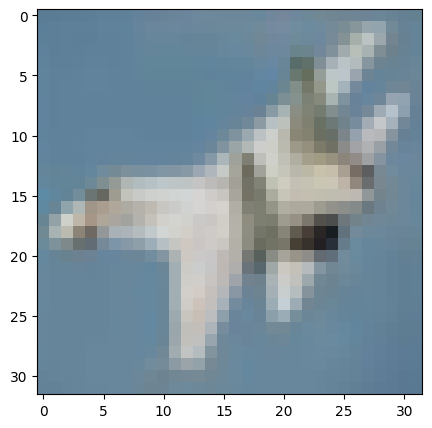

Label: dog and Prediction: frog


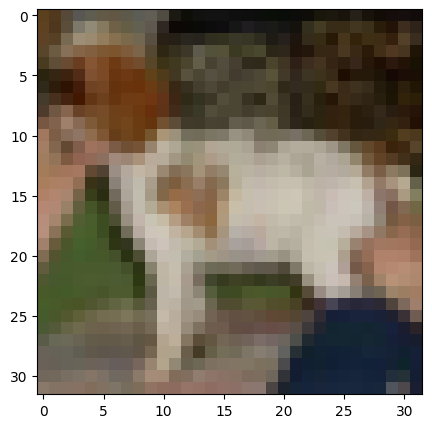

Label: horse and Prediction: truck


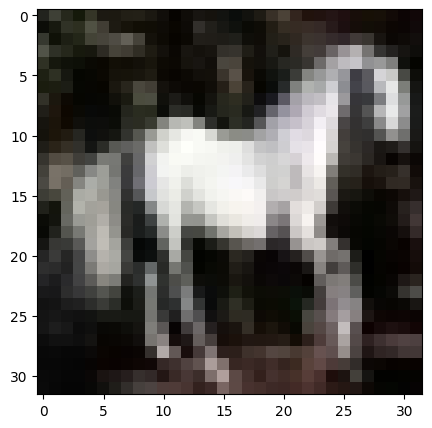

Label: horse and Prediction: cat


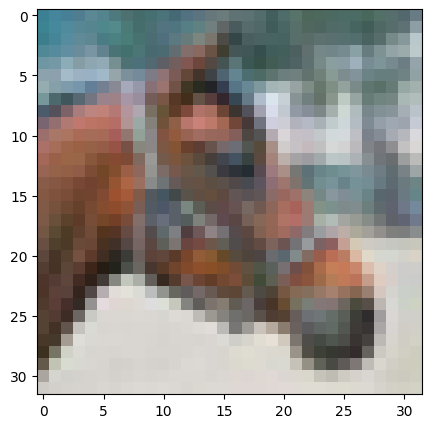

Label: deer and Prediction: bird


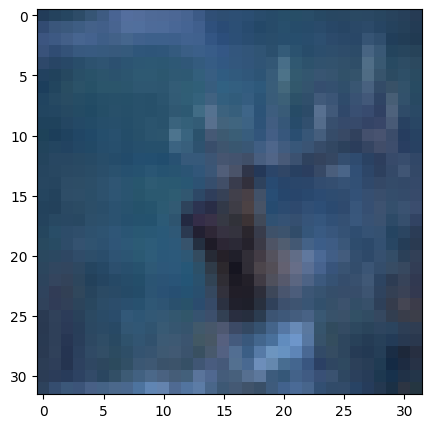

Label: dog and Prediction: deer


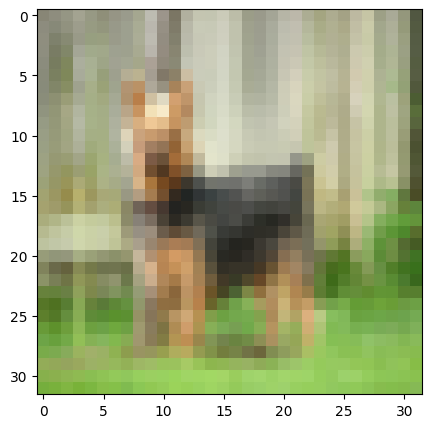

In [45]:
for idx in mismatches[0][:10]:
  plt.figure(figsize=(5,5))
  img, label = test[idx]
  imshow(img)
  print(f'Label: {classes[label]} and Prediction: {classes[predictions[idx]]}')
  plt.show()

Sumamry:

- The model used is a Cifar_Baseline, which is a convolutional neural network with three convolution blocks, each followed by a transition block.
- The model achieved a training accuracy of 60% and a validation accuracy of 61%.
- The model's training loss was 1.15 and its validation loss was 1.01.
- The model's confusion matrix showed that it was most accurate at classifying Autombile and least accurate at classifying Cats.
- Early stopping was triggered after N epochs due to lack of improvement in validation loss.
- LayerNorm doesnot work well in case of CNN

## Links:
https://medium.com/@zljdanceholic/groupnorm-then-batchnorm-instancenorm-layernorm-e2b2a1d350a0
https://wandb.ai/wandb_fc/Normalization/reports/Normalization-Series-What-is-Batch-Norm---VmlldzoxMjk2ODcz
https://wandb.ai/wandb_fc/GroupNorm/reports/Group-Normalization-in-Pytorch-With-Examples---VmlldzoxMzU0MzMy
https://wandb.ai/wandb_fc/LayerNorm/reports/Layer-Normalization-in-Pytorch-With-Examples---VmlldzoxMjk5MTk1
https://wandb.ai/wandb_fc/Normalization-Series/reports/Instance-Normalization-in-PyTorch-With-Examples---VmlldzoxNDIyNTQx

https://www.linkedin.com/pulse/understanding-batch-normalization-layer-group-implementing-pasha-s/

https://becominghuman.ai/all-about-normalization-6ea79e70894b

https://gaoxiangluo.github.io/2021/08/01/Group-Norm-Batch-Norm-Instance-Norm-which-is-better/